In [1]:
import crowdsource

In [ ]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [2]:
from astropy.io import fits

In [3]:
from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

In [4]:
from astroquery.svo_fps import SvoFps

In [5]:
cd ../images

/orange/adamginsburg/jwst/brick/images


In [6]:
ls

f405-f410.fits
jw02221-o001_t001_miri_f2550w_i2d.fits
jw02221-o001_t001_nircam_clear-f410m_i2d.fits
jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
jw02221-o001_t001_nircam_f405n-f444w_i2d_reprj_f410.fits
jw02221-o001_t001_nircam_f444w-f466n_i2d.fits
jw02221-o001_t001_nircam_f444w-f466n_i2d_reprj_f410.fits
jw02221-o003_t002_miri_f2550w_i2d.fits
rgb_466_410_405.fits


In [7]:
fh = fits.open('jw02221-o001_t001_nircam_clear-f410m_i2d.fits')
im1 = fh
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']

wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
obsdate = im1[0].header['DATE-OBS']

In [8]:
data = fh[1].data[1383:1883, 2344:2844]

In [9]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [10]:
import webbpsf
nc = webbpsf.NIRCam()
nc.filter =  'F444W'
nc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
psf_initial = nc.calc_psf(oversample=4, fov_pixels=31)     # returns an astropy.io.fits.HDUlist containing PSF and header


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


In [11]:
import numpy as np

In [12]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter =  'F444W'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F444W
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (68

In [13]:
yy, xx = np.indices([31,31], dtype=float)
grid.x_0 = grid.y_0 = 15.5
psf_model = crowdsource.psf.SimplePSF(stamp=grid(xx,yy))

In [85]:
results  = fit_im(data, psf_model, weight=np.ones_like(data)*5,
                                #psfderiv=np.gradient(-psf_initial[0].data),
                                nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results

Extension None, iteration  1, found   2965 sources;    2 close and  439 faint sources removed.
Extension None, iteration  2, found   1113 sources;   12 close and  577 faint sources removed.
Extension None, iteration  3, found   3313 sources;  111 close and  218 faint sources removed.
Extension None, iteration  4, found   2207 sources;  183 close and  346 faint sources removed.
Extension None, iteration  5, found   1054 sources;  239 close and  264 faint sources removed.
Extension None, iteration  6, found    760 sources;  199 close and  246 faint sources removed.
Extension None, iteration  7, found    675 sources;  225 close and  246 faint sources removed.
Extension None, iteration  8, found    521 sources;  214 close and  270 faint sources removed.
Extension None, iteration  9, found    564 sources;  203 close and  252 faint sources removed.
Extension None, iteration 10, found    514 sources;  215 close and  223 faint sources removed.


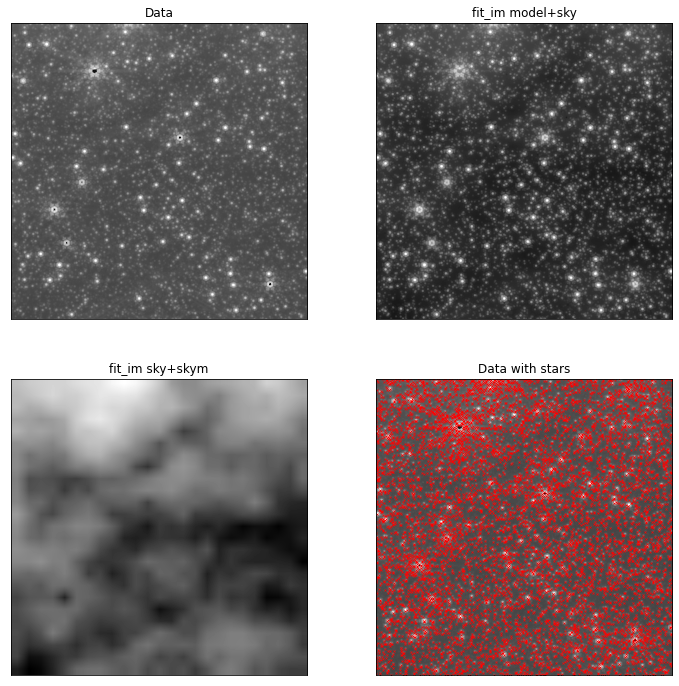

In [94]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

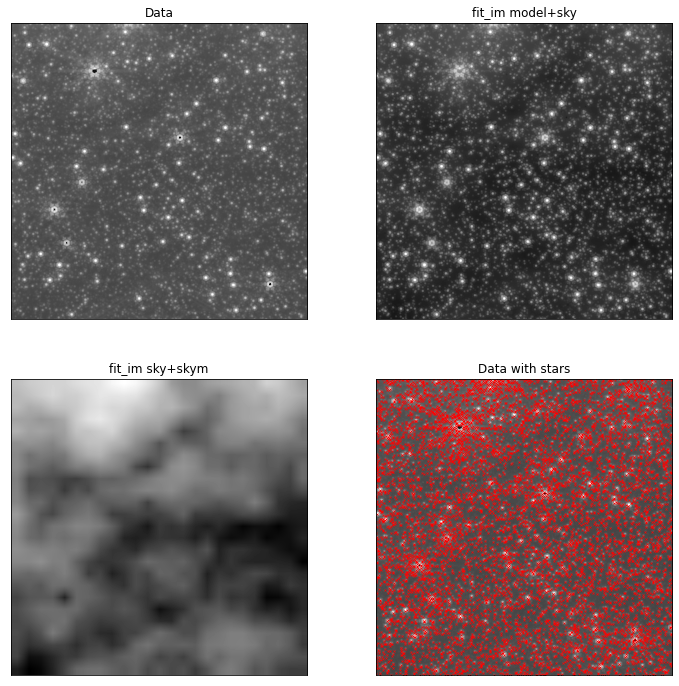

In [95]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

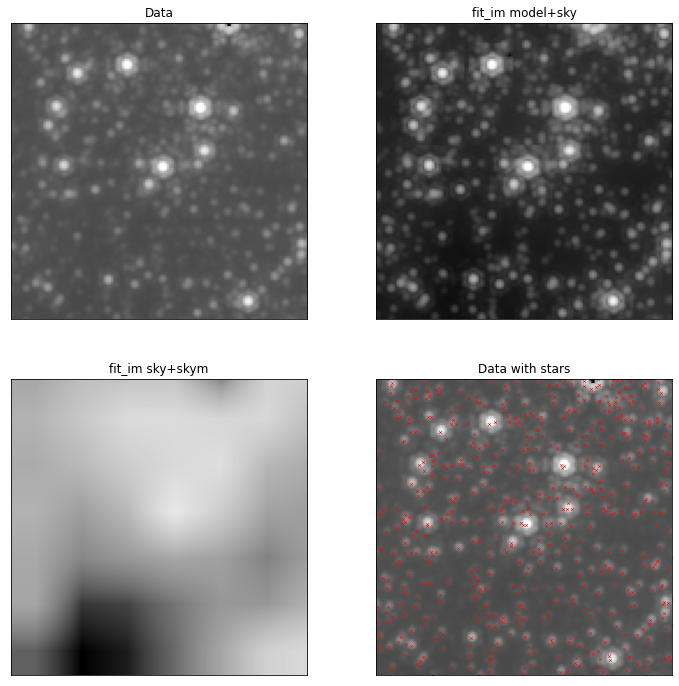

In [96]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky[:128,:128], norm=simple_norm(skymsky[:256,:256], stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

Text(0.5, 1.0, 'Fitted model')

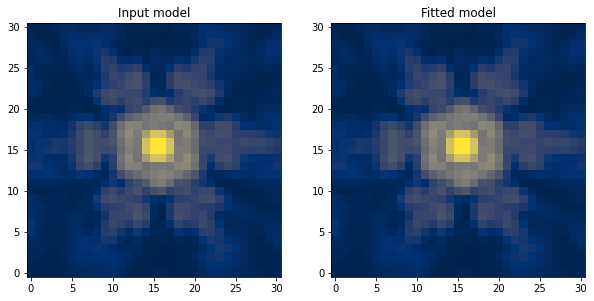

In [97]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input model")
pl.subplot(1,2,2).imshow(psf(30,30), norm=simple_norm(psf(30,30), stretch='log'), cmap='cividis')
pl.title("Fitted model")

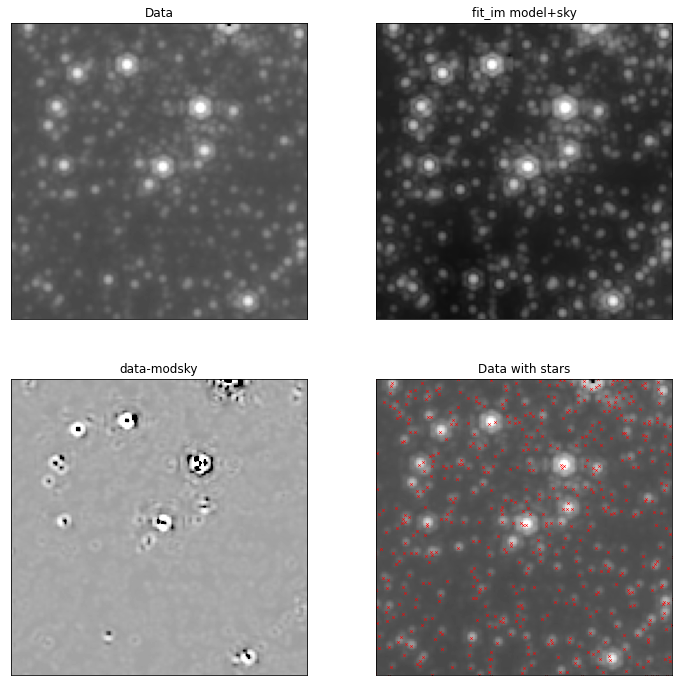

In [98]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");